In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime

# 1) Loading the dataset
Loading the dataset and removing columns that are not needed.

In [2]:
# load the ED visits dataset with all the features
df_event_log_visits = pd.read_csv('df_visits_dur_timeofday-extended.csv')

In [3]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690164 entries, 0 to 690163
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      690164 non-null  object 
 1   SEX                      690164 non-null  object 
 2   DOB                      690160 non-null  object 
 3   DOD                      39962 non-null   object 
 4   ED_POSTAL_CODE           688688 non-null  object 
 5   FACILITY_ID              690164 non-null  object 
 6   FACILITY_NAME            690164 non-null  object 
 7   VISIT_ID                 690164 non-null  object 
 8   VISIT_AGE                690160 non-null  float64
 9   CTAS                     675458 non-null  float64
 10  REASON_FOR_VISIT         682116 non-null  object 
 11  PRESENTING_COMPLAINT     688529 non-null  object 
 12  DEPART_DISPOSITION_ID    686843 non-null  object 
 13  DEPART_DISPOSITION_DESC  686843 non-null  object 
 14  Acti

In [4]:
# dropping columns that were added earlier for analytics
df_event_log_visits.drop(['Earliest_Time'], axis=1, inplace=True)

In [5]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690164 entries, 0 to 690163
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      690164 non-null  object 
 1   SEX                      690164 non-null  object 
 2   DOB                      690160 non-null  object 
 3   DOD                      39962 non-null   object 
 4   ED_POSTAL_CODE           688688 non-null  object 
 5   FACILITY_ID              690164 non-null  object 
 6   FACILITY_NAME            690164 non-null  object 
 7   VISIT_ID                 690164 non-null  object 
 8   VISIT_AGE                690160 non-null  float64
 9   CTAS                     675458 non-null  float64
 10  REASON_FOR_VISIT         682116 non-null  object 
 11  PRESENTING_COMPLAINT     688529 non-null  object 
 12  DEPART_DISPOSITION_ID    686843 non-null  object 
 13  DEPART_DISPOSITION_DESC  686843 non-null  object 
 14  Acti

In [6]:
# Rename the Start_Time column to Activity_End_Time - there is only one time stamp in the dataset which is assumed to be
# when the activity finished
df_event_log_visits.rename(columns={'Start_Time': 'Activity_End_Time'}, inplace=True)

# Drop the End_Time column
df_event_log_visits.drop(columns=['End_Time'], inplace=True)


In [7]:

# Sort the DataFrame by VISIT_ID and Activity_End_Time
df_event_log_visits.sort_values(by=['VISIT_ID', 'Activity_End_Time'], inplace=True)

# Infer Start_Time for each activity using the Activity_End_Time of the previous activity
df_event_log_visits['Start_Time'] = df_event_log_visits['Activity_End_Time'].shift(1)

# Ensure that the Start_Time is not carried over from the last activity of the previous VISIT_ID to the first activity of the next VISIT_ID
df_event_log_visits.loc[df_event_log_visits['VISIT_ID'] != df_event_log_visits['VISIT_ID'].shift(1), 'Start_Time'] = pd.NaT

# For the first activity in each sequence, set Start_Time equal to Activity_End_Time, indicating zero duration
df_event_log_visits.loc[df_event_log_visits['Start_Time'].isna(), 'Start_Time'] = df_event_log_visits['Activity_End_Time']


In [8]:
# these are the remaining columns in the dataset as of now
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 690164 entries, 81741 to 345995
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      690164 non-null  object 
 1   SEX                      690164 non-null  object 
 2   DOB                      690160 non-null  object 
 3   DOD                      39962 non-null   object 
 4   ED_POSTAL_CODE           688688 non-null  object 
 5   FACILITY_ID              690164 non-null  object 
 6   FACILITY_NAME            690164 non-null  object 
 7   VISIT_ID                 690164 non-null  object 
 8   VISIT_AGE                690160 non-null  float64
 9   CTAS                     675458 non-null  float64
 10  REASON_FOR_VISIT         682116 non-null  object 
 11  PRESENTING_COMPLAINT     688529 non-null  object 
 12  DEPART_DISPOSITION_ID    686843 non-null  object 
 13  DEPART_DISPOSITION_DESC  686843 non-null  object 
 14  Activ

In [9]:

# Convert the 'Duration' column to timedelta
df_event_log_visits['Duration'] = pd.to_timedelta(df_event_log_visits['Duration'])

# Rename the column and convert the values to hours
df_event_log_visits['Duration_hours'] = df_event_log_visits['Duration'].dt.total_seconds() / 3600

# Drop the old 'Duration' column
df_event_log_visits = df_event_log_visits.drop(columns=['Duration'])


In [10]:

# filtering out the columns I move to the end
columns = list(df_event_log_visits.columns)
columns.remove('Activity_End_Time')
columns.remove('Duration_hours')


# Appending them
columns = columns + ['Activity_End_Time', 'Duration_hours']

# Reordring based on the new column order
df_event_log_visits = df_event_log_visits[columns]

df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,REASON_FOR_VISIT,PRESENTING_COMPLAINT,DEPART_DISPOSITION_ID,DEPART_DISPOSITION_DESC,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours
81741,STDY147061,F,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SOB/COUGH PRODUCTIVE,SHORTNESS OF BREATH,D,DISCHARGED W/O SUPPORT SERV,Triage,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:22:00+00:00,0.550000
81742,STDY147061,F,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SOB/COUGH PRODUCTIVE,SHORTNESS OF BREATH,D,DISCHARGED W/O SUPPORT SERV,Providing service,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.550000
81743,STDY147061,F,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SOB/COUGH PRODUCTIVE,SHORTNESS OF BREATH,D,DISCHARGED W/O SUPPORT SERV,Assessment,Early Morning to Morning,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.550000
81744,STDY147061,F,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SOB/COUGH PRODUCTIVE,SHORTNESS OF BREATH,D,DISCHARGED W/O SUPPORT SERV,Patient departed,Early Morning to Morning,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.550000
494318,STDY321073,M,1999-02-08,NaN,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,L ANKLE INJURY,LOWER EXTREMITY INJURY,D,DISCHARGED W/O SUPPORT SERV,Triage,Early Morning to Morning,2022-04-01 00:40:00+00:00,2022-04-01 00:40:00+00:00,5.333333


In [11]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 690164 entries, 81741 to 345995
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      690164 non-null  object 
 1   SEX                      690164 non-null  object 
 2   DOB                      690160 non-null  object 
 3   DOD                      39962 non-null   object 
 4   ED_POSTAL_CODE           688688 non-null  object 
 5   FACILITY_ID              690164 non-null  object 
 6   FACILITY_NAME            690164 non-null  object 
 7   VISIT_ID                 690164 non-null  object 
 8   VISIT_AGE                690160 non-null  float64
 9   CTAS                     675458 non-null  float64
 10  REASON_FOR_VISIT         682116 non-null  object 
 11  PRESENTING_COMPLAINT     688529 non-null  object 
 12  DEPART_DISPOSITION_ID    686843 non-null  object 
 13  DEPART_DISPOSITION_DESC  686843 non-null  object 
 14  Activ

# 2) Dealing with missing values

## DOB

In [12]:
# DOB is the first column with missing values - there are in total for rows 4 missing values - these rows can be droppped

#  Removing records with missing DOB
df_event_log_visits = df_event_log_visits.dropna(subset=['DOB'])

df_event_log_visits.info()



# Next is DOD, however the missing value in this case indicates that the patient is still alive, hence getting rid of these values 
# would lead to losing important information - this column will be dealt with in later step.


<class 'pandas.core.frame.DataFrame'>
Index: 690160 entries, 81741 to 345995
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      690160 non-null  object 
 1   SEX                      690160 non-null  object 
 2   DOB                      690160 non-null  object 
 3   DOD                      39962 non-null   object 
 4   ED_POSTAL_CODE           688684 non-null  object 
 5   FACILITY_ID              690160 non-null  object 
 6   FACILITY_NAME            690160 non-null  object 
 7   VISIT_ID                 690160 non-null  object 
 8   VISIT_AGE                690160 non-null  float64
 9   CTAS                     675454 non-null  float64
 10  REASON_FOR_VISIT         682112 non-null  object 
 11  PRESENTING_COMPLAINT     688525 non-null  object 
 12  DEPART_DISPOSITION_ID    686839 non-null  object 
 13  DEPART_DISPOSITION_DESC  686839 non-null  object 
 14  Activ

## POSTAL_CODE

In [13]:
# Another column with missing values is the postal code, in this case I decided to fill in the values based on the value of the hospital
# that the patient visited

# Filtering the df to only include rows where ED_POSTAL_CODE is missing
missing_postal_code = df_event_log_visits[df_event_log_visits['ED_POSTAL_CODE'].isnull()]

# Printing the rows with missing ED_POSTAL_CODE
print(missing_postal_code)

               SID SEX         DOB  DOD ED_POSTAL_CODE FACILITY_ID  \
674165  STDY765428   M  1958-07-25  NaN            NaN         SCM   
674167  STDY765428   M  1958-07-25  NaN            NaN         SCM   
674161  STDY765428   M  1958-07-25  NaN            NaN         SCM   
674162  STDY765428   M  1958-07-25  NaN            NaN         SCM   
674166  STDY765428   M  1958-07-25  NaN            NaN         SCM   
...            ...  ..         ...  ...            ...         ...   
690135  STDY768039   F  1997-01-05  NaN            NaN         HSC   
690136  STDY768039   F  1997-01-05  NaN            NaN         HSC   
690139  STDY768039   F  1997-01-05  NaN            NaN         HSC   
690141  STDY768039   F  1997-01-05  NaN            NaN         HSC   
690137  STDY768039   F  1997-01-05  NaN            NaN         HSC   

                                FACILITY_NAME      VISIT_ID  VISIT_AGE  CTAS  \
674165  St. Clares Mercy Hospital - St. Johns  VISIT2210420      63.75   5.0   

In [14]:
# Counting occurrences of each FACILITY_ID in the DataFrame with missing postal codes
facility_counts = missing_postal_code['FACILITY_ID'].value_counts()

# Printing the counts
print(facility_counts)


FACILITY_ID
HSC    756
SCM    421
GBC    158
CGH    107
BUR     34
Name: count, dtype: int64


In [15]:
facility_postal_map = {
    'HSC': 'A1B 3V6',
    'GBC': 'A5A 1K3',
    'SCM': 'A1C 5B8',
    'BUR': 'A0E 1E0',
    'CGH': 'A1Y 1A4'
}

# Applying the map to the 'FACILITY_ID' column to create a new 'Imputed_Postal_Code' column
df_event_log_visits['Imputed_Postal_Code'] = df_event_log_visits['FACILITY_ID'].map(facility_postal_map)

# Filling missing 'ED_POSTAL_CODE' values with the imputed values from 'Imputed_Postal_Code'
df_event_log_visits['ED_POSTAL_CODE'].fillna(df_event_log_visits['Imputed_Postal_Code'], inplace=True)

# dropping the column
df_event_log_visits.drop('Imputed_Postal_Code', axis=1, inplace=True)


In [16]:
# Checking if there are any remaining missing values in 'ED_POSTAL_CODE'
print(df_event_log_visits['ED_POSTAL_CODE'].isnull().sum())


0


In [17]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 690160 entries, 81741 to 345995
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      690160 non-null  object 
 1   SEX                      690160 non-null  object 
 2   DOB                      690160 non-null  object 
 3   DOD                      39962 non-null   object 
 4   ED_POSTAL_CODE           690160 non-null  object 
 5   FACILITY_ID              690160 non-null  object 
 6   FACILITY_NAME            690160 non-null  object 
 7   VISIT_ID                 690160 non-null  object 
 8   VISIT_AGE                690160 non-null  float64
 9   CTAS                     675454 non-null  float64
 10  REASON_FOR_VISIT         682112 non-null  object 
 11  PRESENTING_COMPLAINT     688525 non-null  object 
 12  DEPART_DISPOSITION_ID    686839 non-null  object 
 13  DEPART_DISPOSITION_DESC  686839 non-null  object 
 14  Activ

## CTAS

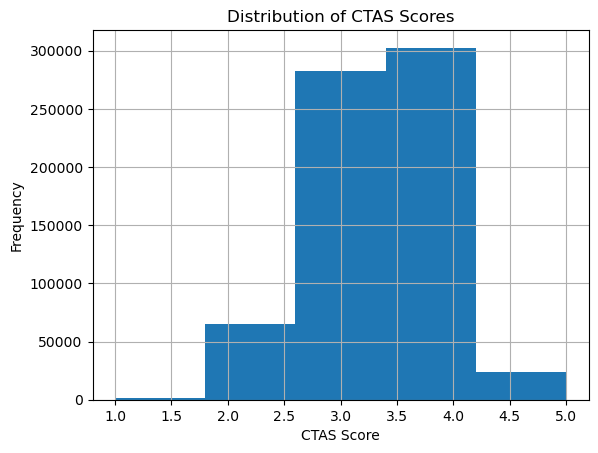

count    675454.000000
mean          3.417567
std           0.720040
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: CTAS, dtype: float64


In [18]:
# Next missing values are in the case of CTAS column 

# Histogram to see the distribution of CTAS scores
df_event_log_visits['CTAS'].hist(bins=5)
plt.title('Distribution of CTAS Scores')
plt.xlabel('CTAS Score')
plt.ylabel('Frequency')
plt.show()

# Descriptive statistics
print(df_event_log_visits['CTAS'].describe())


In [19]:
# Check for rows where CTAS is missing
missing_ctas_df = df_event_log_visits[df_event_log_visits['CTAS'].isna()]

# Display how many of these have 'TLWBS' or 'RLWBS' as the depart_disposition_id
missing_ctas_dispositions = missing_ctas_df['DEPART_DISPOSITION_ID'].value_counts()
print(missing_ctas_dispositions)


DEPART_DISPOSITION_ID
D        5159
ADM      4272
RLWBS    1301
TLWBS    1002
TTO       629
AMA        34
EXP        22
TL         15
ITLBC       3
Name: count, dtype: int64


In [20]:

# Calculate the total counts of each DEPART_DISPOSITION_ID in the whole dataset
total_dispositions = df_event_log_visits['DEPART_DISPOSITION_ID'].value_counts()

# Calculate proportions for the missing CTAS group
missing_ctas_proportions = missing_ctas_dispositions / missing_ctas_dispositions.sum()

# Calculate proportions for the whole dataset
total_proportions = total_dispositions / total_dispositions.sum()

# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Missing_CTAS_Proportion': missing_ctas_proportions,
    'Total_Proportion': total_proportions
})

# Display the DataFrame
print(comparison_df)


                       Missing_CTAS_Proportion  Total_Proportion
DEPART_DISPOSITION_ID                                           
ADM                                   0.343491          0.080236
ALBT                                       NaN          0.000345
AMA                                   0.002734          0.001061
D                                     0.414811          0.793282
DOA                                        NaN          0.000010
DS                                         NaN          0.000108
EXP                                   0.001769          0.000796
ITLBC                                 0.000241          0.002881
RLWBS                                 0.104607          0.003424
TA                                         NaN          0.000683
TC                                         NaN          0.000147
TCC                                        NaN          0.000039
TGSL                                       NaN          0.000012
TL                       

After imputation, remaining missing values in 'CTAS': 0


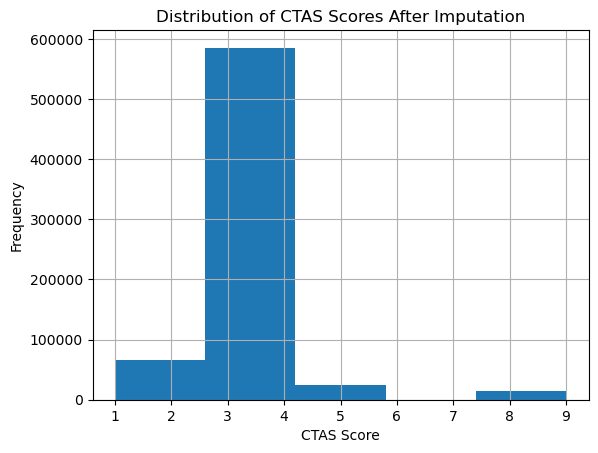

In [21]:
# A significant proportion of 'RLWBS' (25.02%) and 'TLWBS' (6.41%) is in the missing CTAS dataset, this is higher compared
# to their proportions in the entire dataset (0.26% and 10.80% respectively). I will code it “9”.

# Coding missing CTAS values as 9
df_event_log_visits['CTAS'].fillna(9, inplace=True)


# Verifying no missing values
print(f"After imputation, remaining missing values in 'CTAS': {df_event_log_visits['CTAS'].isnull().sum()}")

# the distribution after imputation
df_event_log_visits['CTAS'].hist(bins=5)
plt.title('Distribution of CTAS Scores After Imputation')
plt.xlabel('CTAS Score')
plt.ylabel('Frequency')
plt.show()

In [22]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 690160 entries, 81741 to 345995
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      690160 non-null  object 
 1   SEX                      690160 non-null  object 
 2   DOB                      690160 non-null  object 
 3   DOD                      39962 non-null   object 
 4   ED_POSTAL_CODE           690160 non-null  object 
 5   FACILITY_ID              690160 non-null  object 
 6   FACILITY_NAME            690160 non-null  object 
 7   VISIT_ID                 690160 non-null  object 
 8   VISIT_AGE                690160 non-null  float64
 9   CTAS                     690160 non-null  float64
 10  REASON_FOR_VISIT         682112 non-null  object 
 11  PRESENTING_COMPLAINT     688525 non-null  object 
 12  DEPART_DISPOSITION_ID    686839 non-null  object 
 13  DEPART_DISPOSITION_DESC  686839 non-null  object 
 14  Activ

## REASON_FOR_VISIT 

In [23]:
df_event_log_visits['REASON_FOR_VISIT'].nunique()

38425

In [24]:
## too many values - decided to drop the column  
df_event_log_visits.drop(columns=['REASON_FOR_VISIT'], inplace=True)


## PRESENTING_COMPLAINT 

In [25]:
df_event_log_visits['PRESENTING_COMPLAINT'].nunique()

177

In [26]:
# Drop rows with missing values in the PRESENTING_COMPLAINT column
df_event_log_visits.dropna(subset=['PRESENTING_COMPLAINT'], inplace=True)


In [27]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 688525 entries, 81741 to 345995
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      688525 non-null  object 
 1   SEX                      688525 non-null  object 
 2   DOB                      688525 non-null  object 
 3   DOD                      39472 non-null   object 
 4   ED_POSTAL_CODE           688525 non-null  object 
 5   FACILITY_ID              688525 non-null  object 
 6   FACILITY_NAME            688525 non-null  object 
 7   VISIT_ID                 688525 non-null  object 
 8   VISIT_AGE                688525 non-null  float64
 9   CTAS                     688525 non-null  float64
 10  PRESENTING_COMPLAINT     688525 non-null  object 
 11  DEPART_DISPOSITION_ID    685204 non-null  object 
 12  DEPART_DISPOSITION_DESC  685204 non-null  object 
 13  Activity                 688525 non-null  object 
 14  TIME_

## DEPART_DISPOSITION_ID

In [28]:
# Departing disposition is one of the values I will be predicting with the model 
# (TRIAGED LEFT W/O BEING SEEN and REGISTERED LEFT W/O BEING SEEN)
# hence I decided to not deal with the missing values at this moment - however, we only need one of the columns
df_event_log_visits['DEPART_DISPOSITION_DESC'].unique()

array(['DISCHARGED W/O SUPPORT SERV', 'ADMITTED',
       'TRIAGED LEFT W/O BEING SEEN', 'TRANSFER TO OTHER',
       'REGISTERED LEFT W/O BEING SEEN', 'INIT RX LEFT BEFORE COMPLETE',
       'TRANSFER TO OTHER ACUTE CARE', 'LEFT AGAINST MEDICAL ADVICE', nan,
       'DIED IN FACILITY', 'ASSESSED LEFT BEFORE TREATMENT',
       'TRANSFER TO CONTINUING CARE', 'DISCHARGED WITH SUPPORT SERV',
       'TRANSFER TO LONG TERM CARE', 'DOA',
       'TRSF TO CORRECTIONAL FACILITY', 'TRANSFER TO GROUP SUPP LIVING'],
      dtype=object)

In [29]:
df_event_log_visits.drop(['DEPART_DISPOSITION_DESC'], axis=1, inplace=True)

In [30]:
dispositions_counts =  df_event_log_visits['DEPART_DISPOSITION_ID'].value_counts()

# Print the counts
print(dispositions_counts)

DEPART_DISPOSITION_ID
D        544769
TLWBS     71598
ADM       53595
TTO        8262
RLWBS      2352
ITLBC      1979
AMA         729
EXP         547
TA          469
TL          450
ALBT        237
TC          101
DS           74
TCC          27
TGSL          8
DOA           7
Name: count, dtype: int64


# 3) Preprocessing columns
In the next steps I am preprocessing and cleaning data in all columns that will be used by the deep learning model.

## SEX

In [31]:
# preprocessing the SEX column

df_event_log_visits['SEX'].value_counts()

SEX
F    376616
M    311832
U        77
Name: count, dtype: int64

In [32]:
# Encode 'M' as 0 and 'F' as 1 and 'U' as 2
df_event_log_visits['SEX'] = df_event_log_visits['SEX'].map({'M': 0, 'F': 1, 'U': 2})
df_event_log_visits

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,PRESENTING_COMPLAINT,DEPART_DISPOSITION_ID,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours
81741,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SHORTNESS OF BREATH,D,Triage,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:22:00+00:00,0.550000
81742,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SHORTNESS OF BREATH,D,Providing service,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.550000
81743,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SHORTNESS OF BREATH,D,Assessment,Early Morning to Morning,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.550000
81744,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,SHORTNESS OF BREATH,D,Patient departed,Early Morning to Morning,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.550000
494318,STDY321073,0,1999-02-08,NaN,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,LOWER EXTREMITY INJURY,D,Triage,Early Morning to Morning,2022-04-01 00:40:00+00:00,2022-04-01 00:40:00+00:00,5.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600817,STDY586460,1,1989-07-22,NaN,A1B0G5,HSC,Health Sciences Centre - St. Johns,VISIT2377969,33.750000,4.0,"LUMP,BUMPS,CALLUSES",TLWBS,Patient departed,Evening to Night,2023-04-30 23:51:00+00:00,2023-05-01 02:30:00+00:00,2.750000
345992,STDY258323,1,1961-03-12,NaN,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,COUGH/CONGESTION,D,Triage,Evening to Night,2023-04-30 23:45:00+00:00,2023-04-30 23:45:00+00:00,8.233333
345993,STDY258323,1,1961-03-12,NaN,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,COUGH/CONGESTION,D,Providing service,Evening to Night,2023-04-30 23:45:00+00:00,2023-04-30 23:52:00+00:00,8.233333
345994,STDY258323,1,1961-03-12,NaN,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,COUGH/CONGESTION,D,Assessment,Evening to Night,2023-04-30 23:52:00+00:00,2023-05-01 07:50:00+00:00,8.233333


## DATE OF BIRTH

In [33]:
# preprocessing the DOB column

# converting the 'DOB' column to datetime
df_event_log_visits['DOB'] = pd.to_datetime(df_event_log_visits['DOB'])


## PRESENTING_COMPLAINT

In [34]:

from sklearn.preprocessing import LabelEncoder


# Apply label encoding
label_encoder = LabelEncoder()
df_event_log_visits['PRESENTING_COMPLAINT_ENCODED'] = label_encoder.fit_transform(df_event_log_visits['PRESENTING_COMPLAINT'])

# Drop the original PRESENTING_COMPLAINT column
df_event_log_visits.drop(columns=['PRESENTING_COMPLAINT'], inplace=True)

df_event_log_visits.head(5)

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,DEPART_DISPOSITION_ID,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours,PRESENTING_COMPLAINT_ENCODED
81741,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Triage,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:22:00+00:00,0.550000,141
81742,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Providing service,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.550000,141
81743,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Assessment,Early Morning to Morning,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.550000,141
81744,STDY147061,1,1959-07-14,NaN,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Patient departed,Early Morning to Morning,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.550000,141
494318,STDY321073,0,1999-02-08,NaN,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,D,Triage,Early Morning to Morning,2022-04-01 00:40:00+00:00,2022-04-01 00:40:00+00:00,5.333333,94


## 3.1) Creating new features based on the old features
Here, I am creating new features based on the available features in the dataset.

## DATE OF DEATH and IS_DECEASED

In [35]:
# Preprocessing the DOD column by creating a binary indicator from DOD
df_event_log_visits['Is_Deceased'] = df_event_log_visits['DOD'].notnull().astype(int)

df_event_log_visits['DOD'] = pd.to_datetime(df_event_log_visits['DOD'], errors='coerce')

df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 688525 entries, 81741 to 345995
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   SID                           688525 non-null  object        
 1   SEX                           688525 non-null  int64         
 2   DOB                           688525 non-null  datetime64[ns]
 3   DOD                           39472 non-null   datetime64[ns]
 4   ED_POSTAL_CODE                688525 non-null  object        
 5   FACILITY_ID                   688525 non-null  object        
 6   FACILITY_NAME                 688525 non-null  object        
 7   VISIT_ID                      688525 non-null  object        
 8   VISIT_AGE                     688525 non-null  float64       
 9   CTAS                          688525 non-null  float64       
 10  DEPART_DISPOSITION_ID         685204 non-null  object        
 11  Activity      

In [36]:

# inspecting the unique values in 'DEPART_DISPOSITION_ID' when 'Is_Deceased' is True
deceased_dispositions = df_event_log_visits[df_event_log_visits['Is_Deceased'] == 1]['DEPART_DISPOSITION_ID'].value_counts()

# A cross-tabulation to see the relationship more clearly
crosstab = pd.crosstab(df_event_log_visits['Is_Deceased'], df_event_log_visits['DEPART_DISPOSITION_ID'])

print("Distribution of departure dispositions for deceased cases:")
print(deceased_dispositions)

print("\nCross-tabulation of 'Is_Deceased' and 'DEPART_DISPOSITION_ID':")
print(crosstab)


Distribution of departure dispositions for deceased cases:
DEPART_DISPOSITION_ID
D        22359
ADM      12691
TLWBS     1511
TTO       1173
EXP        547
ITLBC      159
TL         105
AMA         84
TA          59
RLWBS       53
DOA          7
TC           7
Name: count, dtype: int64

Cross-tabulation of 'Is_Deceased' and 'DEPART_DISPOSITION_ID':
DEPART_DISPOSITION_ID    ADM  ALBT  AMA       D  DOA  DS  EXP  ITLBC  RLWBS  \
Is_Deceased                                                                   
0                      40904   237  645  522410    0  74    0   1820   2299   
1                      12691     0   84   22359    7   0  547    159     53   

DEPART_DISPOSITION_ID   TA  TC  TCC  TGSL   TL  TLWBS   TTO  
Is_Deceased                                                  
0                      410  94   27     8  345  70087  7089  
1                       59   7    0     0  105   1511  1173  


In [37]:

df_event_log_visits['DOD'] = pd.to_datetime(df_event_log_visits['DOD'], errors='coerce').dt.tz_localize(None).dt.tz_localize('UTC')

# comparisons
df_event_log_visits['Died_Before_Visit'] = (df_event_log_visits['DOD'] < df_event_log_visits['Start_Time']).astype(int)
df_event_log_visits['Died_During_Visit'] = ((df_event_log_visits['DOD'] >= df_event_log_visits['Start_Time']) & 
                                            (df_event_log_visits['DOD'] <= df_event_log_visits['Activity_End_Time'])).astype(int)
df_event_log_visits['Died_After_Visit'] = (df_event_log_visits['DOD'] > df_event_log_visits['Activity_End_Time']).astype(int)


In [38]:
# Filtering for rows where 'Is_Deceased' is 1 and display the first few rows
deceased_visits = df_event_log_visits[df_event_log_visits['Is_Deceased'] == 1]
deceased_visits.head()


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours,PRESENTING_COMPLAINT_ENCODED,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit
428671,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,...,Triage,Early Morning to Morning,2022-04-01 02:50:00+00:00,2022-04-01 02:50:00+00:00,4.0,147,1,0,0,1
428672,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,...,Providing service,Early Morning to Morning,2022-04-01 02:50:00+00:00,2022-04-01 02:59:00+00:00,4.0,147,1,0,0,1
428673,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,...,Assessment,Early Morning to Morning,2022-04-01 02:59:00+00:00,2022-04-01 06:30:00+00:00,4.0,147,1,0,0,1
428674,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,...,Patient departed,Early Morning to Morning,2022-04-01 06:30:00+00:00,2022-04-01 06:50:00+00:00,4.0,147,1,0,0,1
514422,STDY327615,0,1963-08-25,2022-04-04 00:00:00+00:00,A1B5C4,HSC,Health Sciences Centre - St. Johns,VISIT2208489,58.666667,3.0,...,Triage,Late Morning to Late Afternoon,2022-04-01 09:30:00+00:00,2022-04-01 09:30:00+00:00,8.0,18,1,0,0,1


In [39]:
# checking counts:
died_before_visit_count = df_event_log_visits[df_event_log_visits['Died_Before_Visit'] == 1].shape[0]
print("Number of cases where death occurred before the visit:", died_before_visit_count)

died_during_visit_count = df_event_log_visits[df_event_log_visits['Died_During_Visit'] == 1].shape[0]
print("Number of cases where death occurred during the visit:", died_during_visit_count)

died_after_visit_count = df_event_log_visits[df_event_log_visits['Died_After_Visit'] == 1].shape[0]
print("Number of cases where death occurred after the visit:", died_after_visit_count)


Number of cases where death occurred before the visit: 907
Number of cases where death occurred during the visit: 692
Number of cases where death occurred after the visit: 37873


## AREA_TYPE

In [40]:
# identifying rural or urban area based on the postal code according to
# https://www.canadapost-postescanada.ca/cpc/en/support/articles/addressing-guidelines/postal-codes.page

# Function to determine if a postal code is urban or rural
def urban_rural_classifier(postal_code):
    # Check the second character of the postal code
    if postal_code[1] == '0':
        return 'rural'
    else:
        return 'urban'

# Apply the function to classify each postal code
df_event_log_visits['Area_Type'] = df_event_log_visits['ED_POSTAL_CODE'].apply(urban_rural_classifier)

# Verify by displaying the DataFrame
print(df_event_log_visits[['ED_POSTAL_CODE', 'Area_Type']].head())

       ED_POSTAL_CODE Area_Type
81741          A0A2B0     rural
81742          A0A2B0     rural
81743          A0A2B0     rural
81744          A0A2B0     rural
494318         A1B1Z6     urban


In [41]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 688525 entries, 81741 to 345995
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_ID

## COORDINATES

In [42]:
# adding latutide and longitude table from geonames
file_path = 'CA_full.txt'
postal_codes = pd.read_csv(file_path, delimiter='\t', names=[
    'Country', 'Postal_Code', 'Place_Name', 'Province', 'Province_Code',
    'Unnamed5', 'Unnamed6', 'Unnamed7', 'Unnamed8', 'Latitude', 'Longitude', 'Extra'
], skiprows=1)  # skiprows=1 to skip the example header row you pasted

# Dropping the unnecessary columns
postal_codes.drop(columns=['Unnamed5', 'Unnamed6', 'Unnamed7', 'Unnamed8', 'Extra'], inplace=True)

# Displaying the dataframe to ensure it loaded correctly
print(postal_codes.head())


  Country Postal_Code    Place_Name Province Province_Code  Latitude  \
0      CA     T0A 0A1   Saddle Lake  Alberta            AB   54.0029   
1      CA     T0A 0A2  Cherry Grove  Alberta            AB   54.3603   
2      CA     T0A 0A3       Glendon  Alberta            AB   54.3455   
3      CA     T0A 0A4     Lindbergh  Alberta            AB   54.3455   
4      CA     T0A 0A5       St Lina  Alberta            AB   54.3455   

   Longitude  
0  -111.7000  
1  -110.0863  
2  -111.6157  
3  -111.6157  
4  -111.6157  


In [43]:
# checking for duplicates 

print(postal_codes['Postal_Code'].duplicated().sum())
postal_codes = postal_codes.drop_duplicates(subset=['Postal_Code'], keep='first')


891


In [44]:
# Merging the dataframes
df_event_log_visits = df_event_log_visits.merge(postal_codes, left_on='ED_POSTAL_CODE', right_on='Postal_Code', how='left')

# Checking for missing latitude and longitude after the merge
print(df_event_log_visits[['Latitude', 'Longitude']].isnull().sum())


Latitude     687049
Longitude    687049
dtype: int64


In [45]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_I

In [46]:
# some of the postal codes can not be found on geonames as they are - the closest coordinates can be found by using
# only the first three digits
postal_codes['First_3_Digits'] = postal_codes['Postal_Code'].str[:3]


In [47]:
# rows where 'Latitude' or 'Longitude' is missing 
df_event_log_visits_missing_lat = df_event_log_visits[df_event_log_visits['Latitude'].isnull() | df_event_log_visits['Longitude'].isnull()]

# creating nnew column
df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]
df_event_log_visits_missing_lat

C:\Users\ksteflova\AppData\Local\Temp\ipykernel_3452\2478119479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Died_After_Visit,Area_Type,Country,Postal_Code,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits
0,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
1,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
2,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
3,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
4,STDY321073,0,1999-02-08,NaT,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688520,STDY586460,1,1989-07-22,NaT,A1B0G5,HSC,Health Sciences Centre - St. Johns,VISIT2377969,33.750000,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1B
688521,STDY258323,1,1961-03-12,NaT,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1E
688522,STDY258323,1,1961-03-12,NaT,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1E
688523,STDY258323,1,1961-03-12,NaT,A1E3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1E


In [48]:

# Optimize data types
df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits_missing_lat['First_3_Digits'].astype('category')
postal_codes['First_3_Digits'] = postal_codes['First_3_Digits'].astype('category')

# Select only relevant columns for the merge
df_event_log_visits_missing_lat = df_event_log_visits_missing_lat[['First_3_Digits']]
postal_codes = postal_codes[['First_3_Digits', 'Latitude', 'Longitude']]

# Perform the merge
df_merged = df_event_log_visits_missing_lat.merge(postal_codes, on='First_3_Digits', how='left', suffixes=('', '_pc'))

# Display the merged DataFrame
print(df_merged.head())


C:\Users\ksteflova\AppData\Local\Temp\ipykernel_3452\2549043629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits_missing_lat['First_3_Digits'].astype('category')


  First_3_Digits  Latitude  Longitude
0            A0A   47.4234   -53.1966
1            A0A   47.3856   -53.1341
2            A0A   46.7372   -53.3638
3            A0A   47.5370   -53.2699
4            A0A   47.9437   -53.0682


In [49]:
# adding new column to the original dataset to merge on
df_event_log_visits['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Died_After_Visit,Area_Type,Country,Postal_Code,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits
0,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
1,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
2,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
3,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A0A
4,STDY321073,0,1999-02-08,NaT,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1B


In [50]:
# Find the rows in the main dataset where latitude and longitude are missing
missing_indices = df_event_log_visits[df_event_log_visits['Latitude'].isna() & df_event_log_visits['Longitude'].isna()].index

# Update the main dataset with the latitude and longitude from the merged DataFrame
df_event_log_visits.loc[missing_indices, 'Latitude'] = df_merged['Latitude']
df_event_log_visits.loc[missing_indices, 'Longitude'] = df_merged['Longitude']

# Check if the missing values are updated
print(df_event_log_visits.loc[missing_indices, ['First_3_Digits', 'Latitude', 'Longitude']])


       First_3_Digits  Latitude  Longitude
0                 A0A   47.4234   -53.1966
1                 A0A   47.3856   -53.1341
2                 A0A   46.7372   -53.3638
3                 A0A   47.5370   -53.2699
4                 A1B   47.9437   -53.0682
...               ...       ...        ...
688520            A1B   47.5595   -52.7326
688521            A1E   47.5744   -52.6995
688522            A1E   47.5754   -52.7027
688523            A1E   47.5747   -52.7000
688524            A1E   47.5736   -52.7093

[687049 rows x 3 columns]


In [51]:
# an overview of all missing values in the DataFrame
print(df_event_log_visits.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_I

In [52]:
# Dropping rows where either Latitude or Longitude is missing (3 rows)
df_event_log_visits = df_event_log_visits.dropna(subset=['Latitude', 'Longitude'])

# Verifying the result
print(df_event_log_visits[['Latitude', 'Longitude']].isnull().sum())


Latitude     0
Longitude    0
dtype: int64


In [53]:

# Assuming 'First_3_Digits' represents the first 3 digits of postal codes

# List of postal codes corresponding to Conception Bay ('A1X', 'A1W' - CBS , 'A0A', 'A1Y' - CBN)
conception_bay_postal_codes = ['A1X', 'A1W', 'A0A', 'A1Y']

# Filter the dataset for Conception Bay postal codes
cbn_data = df_event_log_visits[df_event_log_visits['First_3_Digits'].isin(conception_bay_postal_codes)]

# Create a cross-tabulation of postal codes with hospital sites
cross_tab = pd.crosstab(cbn_data['First_3_Digits'], cbn_data['FACILITY_NAME'])

# Output the cross-tabulation
cross_tab


FACILITY_NAME,Burin Peninsula Health care Centre - Burin,Carbonear General Hospital - Carbonear,Dr. G.B. Cross Memorial Hospital - Clarenville,Health Sciences Centre - St. Johns,St. Clares Mercy Hospital - St. Johns
First_3_Digits,,,,,
A0A,166,87009,534,18244,13519
A1W,76,229,113,9396,4600
A1X,83,437,158,15040,7327
A1Y,12,30522,84,908,304


## DISTANCE_TO_HOSPITAL

In [54]:
from geopy.distance import geodesic

# Hospital coordinates dictionary (includes all hospitals)
hospital_coords = {
    'Health Sciences Centre - St. Johns': (47.57173844188426, -52.7428752808959),
    'St. Clares Mercy Hospital - St. Johns': (47.55783035337661, -52.72164112844875),
    'Dr. G.B. Cross Memorial Hospital - Clarenville': (48.165186482963676, -53.98449946306605),
    'Carbonear General Hospital - Carbonear': (47.725414948091, -53.226560474732224),
    'Burin Peninsula Health care Centre - Burin': (47.10500591911938, -55.19465935942642),  
}

# Calculating the distance between a case and a hospital
def calculate_distance(row, hospital_name):
    case_coords = (row['Latitude'], row['Longitude'])
    hospital_coords_tuple = hospital_coords.get(hospital_name, None)  
    if hospital_coords_tuple is None:
        return float('nan')  # Return NaN if the hospital isn't in the dictionary
    return geodesic(case_coords, hospital_coords_tuple).km  # Distance in kilometers

# Applying the function to calculate distances for all hospitals
df_event_log_visits['Distance_to_Hospital'] = df_event_log_visits.apply(
    lambda row: calculate_distance(row, row['FACILITY_NAME']),
    axis=1
)

# Displaying DataFrame with the calculated distances
print(df_event_log_visits[['VISIT_ID', 'FACILITY_NAME', 'Distance_to_Hospital']].head())


       VISIT_ID                           FACILITY_NAME  Distance_to_Hospital
0  VISIT2208402  Carbonear General Hospital - Carbonear             33.654212
1  VISIT2208402  Carbonear General Hospital - Carbonear             38.416728
2  VISIT2208402  Carbonear General Hospital - Carbonear            110.355548
3  VISIT2208402  Carbonear General Hospital - Carbonear             21.200279
4  VISIT2208404      Health Sciences Centre - St. Johns             48.013427


## DRIVING DISTANCE?

In [55]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_I

In [56]:
# the number of unique visit IDs
unique_visit_ids = df_event_log_visits['VISIT_ID'].nunique()
print(f"Number of unique visit IDs: {unique_visit_ids}")

# the number of unique postal codes
unique_postal_codes = df_event_log_visits['ED_POSTAL_CODE'].nunique()
print(f"Number of unique postal codes: {unique_postal_codes}")

Number of unique visit IDs: 130204
Number of unique postal codes: 8991


In [57]:

df = df_event_log_visits

# Extract the relevant columns (postal code, latitude, and longitude)

postal_code_coords = df[['ED_POSTAL_CODE', 'Latitude', 'Longitude']].drop_duplicates()

# Display the unique postal codes with their coordinates
print(postal_code_coords.head())

# Convert the DataFrame to a list of dictionaries
postal_code_coords_list = postal_code_coords.to_dict(orient='records')

# Display the list of dictionaries
print(postal_code_coords_list[:5])  # Display the first 5 entries


  ED_POSTAL_CODE  Latitude  Longitude
0         A0A2B0   47.4234   -53.1966
1         A0A2B0   47.3856   -53.1341
2         A0A2B0   46.7372   -53.3638
3         A0A2B0   47.5370   -53.2699
4         A1B1Z6   47.9437   -53.0682
[{'ED_POSTAL_CODE': 'A0A2B0', 'Latitude': 47.4234, 'Longitude': -53.1966}, {'ED_POSTAL_CODE': 'A0A2B0', 'Latitude': 47.3856, 'Longitude': -53.1341}, {'ED_POSTAL_CODE': 'A0A2B0', 'Latitude': 46.7372, 'Longitude': -53.3638}, {'ED_POSTAL_CODE': 'A0A2B0', 'Latitude': 47.537, 'Longitude': -53.2699}, {'ED_POSTAL_CODE': 'A1B1Z6', 'Latitude': 47.9437, 'Longitude': -53.0682}]


## IS_NL_HOLIDAY

In [58]:
# List of Newfoundland and Labrador holidays in "MM-DD" format
nl_holidays = {
    "01-01",  # New Year's Day
    "03-17",  # St. Patrick's Day
    "04-23",  # St. George's Day
    "06-24",  # Discovery Day
    "07-01",  # Canada Day
    "09-02",  # Labour Day
    "10-14",  # Thanksgiving
    "11-11",  # Remembrance Day
    "12-25",  # Christmas Day
    "12-26"   # Boxing Day
}

# checking if a given date matches a holiday
def is_nl_holiday(date):
    # Extracting month and day from the date
    month_day = date.strftime("%m-%d")
    return month_day in nl_holidays


In [59]:
# Converting 'Start_Time' to datetime 
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Applying the function to create a new column
df_event_log_visits['Is_NL_Holiday'] = df_event_log_visits['Start_Time'].apply(is_nl_holiday)

# Displaying results
print(df_event_log_visits[['Start_Time', 'Is_NL_Holiday']].head())



                 Start_Time  Is_NL_Holiday
0 2022-04-01 00:22:00+00:00          False
1 2022-04-01 00:22:00+00:00          False
2 2022-04-01 00:24:00+00:00          False
3 2022-04-01 00:30:00+00:00          False
4 2022-04-01 00:40:00+00:00          False


## DAY_OF_WEEK and IS_WEEKEND

In [60]:
# Getting the day of the week (0 = Monday, 6 = Sunday)
df_event_log_visits['Day_of_Week'] = pd.to_datetime(df_event_log_visits['Start_Time']).dt.dayofweek
df_event_log_visits['Is_Weekend'] = df_event_log_visits['Day_of_Week'].isin([5, 6])


In [61]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend
0,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,NaN,47.4234,-53.1966,A0A,33.654212,False,4,False
1,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,NaN,47.3856,-53.1341,A0A,38.416728,False,4,False
2,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,NaN,46.7372,-53.3638,A0A,110.355548,False,4,False
3,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,NaN,47.5370,-53.2699,A0A,21.200279,False,4,False
4,STDY321073,0,1999-02-08,NaT,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,NaN,NaN,NaN,47.9437,-53.0682,A1B,48.013427,False,4,False


## VISIT_SEASON

In [62]:
# Defining season ranges
seasons = {
    "Winter": (1, 2, 12),
    "Spring": (3, 4, 5),
    "Summer": (6, 7, 8),
    "Fall": (9, 10, 11)
}

# Function to get the season
def get_season(month):
    for season, months in seasons.items():
        if month in months:
            return season
    return None

df_event_log_visits['Visit_Season'] = df_event_log_visits['Start_Time'].apply(
    lambda x: get_season(pd.to_datetime(x).month)
)


In [63]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Province,Province_Code,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season
0,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,47.4234,-53.1966,A0A,33.654212,False,4,False,Spring
1,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,47.3856,-53.1341,A0A,38.416728,False,4,False,Spring
2,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,46.7372,-53.3638,A0A,110.355548,False,4,False,Spring
3,STDY147061,1,1959-07-14,NaT,A0A2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NaN,NaN,47.5370,-53.2699,A0A,21.200279,False,4,False,Spring
4,STDY321073,0,1999-02-08,NaT,A1B1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,NaN,NaN,47.9437,-53.0682,A1B,48.013427,False,4,False,Spring


## VISIT_FREQUENCY

In [64]:
# Ensuring 'Start_Time' is in datetime format
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Sorting the data
df_event_log_visits.sort_values(by=['SID', 'Start_Time'], inplace=True)

# Identifying the latest visit for each SID
df_event_log_visits['Latest_Visit'] = df_event_log_visits.groupby('SID')['Start_Time'].transform('max')

# Marking rows that correspond to the latest visit
df_event_log_visits['Is_Latest_Visit'] = df_event_log_visits['Start_Time'] == df_event_log_visits['Latest_Visit']

# Counting all unique visits per SID
visit_counts = df_event_log_visits.groupby('SID')['VISIT_ID'].nunique()

# Subtracting 1 from the counts to exclude the current visit (where there are previous visits)
visit_counts = visit_counts - 1

# Ensuring that no negative counts are present (in cases with only one visit)
visit_counts = visit_counts.clip(lower=0)

# Mapping the adjusted visit counts back to the original DataFrame
df_event_log_visits['Visit_Frequency'] = df_event_log_visits['SID'].map(visit_counts)

# Display the result
print(df_event_log_visits[['SID', 'VISIT_ID', 'Visit_Frequency']].head())


               SID      VISIT_ID  Visit_Frequency
550146  STDY111126  VISIT2345092                1
550147  STDY111126  VISIT2345092                1
550148  STDY111126  VISIT2345092                1
550149  STDY111126  VISIT2345092                1
550150  STDY111126  VISIT2345092                1


In [65]:
df_event_log_visits.drop(columns=['Latest_Visit', 'Is_Latest_Visit'], inplace=True)


In [66]:
df_event_log_visits.describe()

,SEX,DOB,VISIT_AGE,CTAS,Duration_hours,PRESENTING_COMPLAINT_ENCODED,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit,Latitude,Longitude,Distance_to_Hospital,Day_of_Week,Visit_Frequency
count,688525.000000,688525,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000
mean,0.547213,1972-08-19 16:44:58.108565408,50.147855,3.537938,23.316454,86.248643,0.057328,0.001317,0.001005,0.055006,47.571263,-53.052311,64.808417,2.912151,2.821574
min,0.000000,1917-04-13 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.272500,-78.893800,0.027117,0.000000,0.000000
25%,0.000000,1954-07-08 00:00:00,32.250000,3.000000,2.050000,32.000000,0.000000,0.000000,0.000000,0.000000,47.526400,-52.868600,4.484503,1.000000,0.000000
50%,1.000000,1970-09-28 00:00:00,52.000000,3.000000,3.950000,90.000000,0.000000,0.000000,0.000000,0.000000,47.560800,-52.754800,29.554909,3.000000,1.000000
75%,1.000000,1990-07-20 00:00:00,68.250000,4.000000,7.083333,141.000000,0.000000,0.000000,0.000000,0.000000,47.592900,-52.717000,106.461409,5.000000,3.000000
max,2.000000,2023-03-27 00:00:00,106.000000,9.000000,4829.850000,176.000000,1.000000,1.000000,1.000000,1.000000,62.416700,-52.660800,2281.546466,6.000000,123.000000
std,0.497991,NaN,22.085160,1.076019,106.763222,55.218070,0.232469,0.036271,0.031687,0.227992,0.395015,1.689343,137.111199,1.995784,7.056141


In [67]:
# 'TLWBS' and 'RLWBS' codes indicate left without being seen
lwbs_codes = ['TLWBS', 'RLWBS']
df_event_log_visits['Is_LWBS'] = df_event_log_visits['DEPART_DISPOSITION_ID'].isin(lwbs_codes).astype(int)



In [68]:

df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Sorting the DataFrame by 'SID' and 'Start_Time'
df_event_log_visits.sort_values(by=['SID', 'Start_Time'], inplace=True)

# Identifying the last visit for each SID
df_event_log_visits['Latest_Visit'] = df_event_log_visits.groupby('SID')['Start_Time'].transform('max')

# Excluding the latest visit from counting
condition = df_event_log_visits['Start_Time'] < df_event_log_visits['Latest_Visit']
df_prior_visits = df_event_log_visits[condition]

# Summing up LWBS occurrences per visit, excluding the latest visit
lwbs_per_visit = df_prior_visits.groupby(['SID', 'VISIT_ID'])['Is_LWBS'].max().groupby('SID').cumsum().reset_index()

# Renaming the column in lwbs_per_visit before merging
lwbs_per_visit.rename(columns={'Is_LWBS': 'Prior_LWBS'}, inplace=True)

# Merging this cumulative count back to the original DataFrame on both SID and VISIT_ID
df_event_log_visits = df_event_log_visits.merge(lwbs_per_visit, on=['SID', 'VISIT_ID'], how='left', suffixes=('', '_cumulative'))

# Replacing NaN with 0 for visits without any prior LWBS events
df_event_log_visits['Prior_LWBS'].fillna(0, inplace=True)

# Dropping the temporary column if no longer needed
df_event_log_visits.drop(columns='Latest_Visit', inplace=True)

# Display the DataFrame to verify results
print(df_event_log_visits[['SID', 'VISIT_ID', 'Prior_LWBS']].head())


          SID      VISIT_ID  Prior_LWBS
0  STDY111126  VISIT2345092         0.0
1  STDY111126  VISIT2345092         0.0
2  STDY111126  VISIT2345092         0.0
3  STDY111126  VISIT2345092         0.0
4  STDY111126  VISIT2345092         0.0


In [69]:
# Filtering rows for SID 'STDY111131' and displaying specific columns
filtered_rows = df_event_log_visits[df_event_log_visits['SID'] == 'STDY111131']
print(filtered_rows[['SID', 'VISIT_ID', 'Prior_LWBS', 'DEPART_DISPOSITION_ID']])


           SID      VISIT_ID  Prior_LWBS DEPART_DISPOSITION_ID
11  STDY111131  VISIT2233914         0.0                     D
12  STDY111131  VISIT2233914         0.0                     D
13  STDY111131  VISIT2233914         0.0                     D
14  STDY111131  VISIT2233914         0.0                     D
15  STDY111131  VISIT2234433         0.0                     D
16  STDY111131  VISIT2234433         0.0                     D
17  STDY111131  VISIT2234433         0.0                     D
18  STDY111131  VISIT2234433         0.0                     D


In [70]:
df_event_log_visits.columns

Index(['SID', 'SEX', 'DOB', 'DOD', 'ED_POSTAL_CODE', 'FACILITY_ID',
       'FACILITY_NAME', 'VISIT_ID', 'VISIT_AGE', 'CTAS',
       'DEPART_DISPOSITION_ID', 'Activity', 'TIME_OF_THE_DAY', 'Start_Time',
       'Activity_End_Time', 'Duration_hours', 'PRESENTING_COMPLAINT_ENCODED',
       'Is_Deceased', 'Died_Before_Visit', 'Died_During_Visit',
       'Died_After_Visit', 'Area_Type', 'Country', 'Postal_Code', 'Place_Name',
       'Province', 'Province_Code', 'Latitude', 'Longitude', 'First_3_Digits',
       'Distance_to_Hospital', 'Is_NL_Holiday', 'Day_of_Week', 'Is_Weekend',
       'Visit_Season', 'Visit_Frequency', 'Is_LWBS', 'Prior_LWBS'],
      dtype='object')

In [71]:
df_event_log_visits.describe()

,SEX,DOB,VISIT_AGE,CTAS,Duration_hours,PRESENTING_COMPLAINT_ENCODED,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit,Latitude,Longitude,Distance_to_Hospital,Day_of_Week,Visit_Frequency,Is_LWBS,Prior_LWBS
count,688525.000000,688525,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000,688525.000000
mean,0.547213,1972-08-19 16:44:58.108565408,50.147855,3.537938,23.316454,86.248643,0.057328,0.001317,0.001005,0.055006,47.571263,-53.052311,64.808417,2.912151,2.821574,0.107404,0.352991
min,0.000000,1917-04-13 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.272500,-78.893800,0.027117,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1954-07-08 00:00:00,32.250000,3.000000,2.050000,32.000000,0.000000,0.000000,0.000000,0.000000,47.526400,-52.868600,4.484503,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1970-09-28 00:00:00,52.000000,3.000000,3.950000,90.000000,0.000000,0.000000,0.000000,0.000000,47.560800,-52.754800,29.554909,3.000000,1.000000,0.000000,0.000000
75%,1.000000,1990-07-20 00:00:00,68.250000,4.000000,7.083333,141.000000,0.000000,0.000000,0.000000,0.000000,47.592900,-52.717000,106.461409,5.000000,3.000000,0.000000,0.000000
max,2.000000,2023-03-27 00:00:00,106.000000,9.000000,4829.850000,176.000000,1.000000,1.000000,1.000000,1.000000,62.416700,-52.660800,2281.546466,6.000000,123.000000,1.000000,48.000000
std,0.497991,NaN,22.085160,1.076019,106.763222,55.218070,0.232469,0.036271,0.031687,0.227992,0.395015,1.689343,137.111199,1.995784,7.056141,0.309626,1.557792


## ED_BUSINESS_HOURLY

In [72]:

# Groupping by hour to get the number of patient arrivals in each hour
arrival_counts = df_event_log_visits.groupby(df_event_log_visits['Start_Time'].dt.floor('H')).size()

# Mappinng the hourly counts back to the original DataFrame
df_event_log_visits['ED_Business_Hourly'] = df_event_log_visits['Start_Time'].dt.floor('H').map(arrival_counts)


print(df_event_log_visits[['Start_Time', 'ED_Business_Hourly']].head())


                 Start_Time  ED_Business_Hourly
0 2023-02-09 09:50:00+00:00                 160
1 2023-02-09 09:50:00+00:00                 160
2 2023-02-09 09:50:00+00:00                 160
3 2023-02-09 09:51:00+00:00                 160
4 2023-02-09 09:51:00+00:00                 160


In [73]:

df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly
0,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,A0B,41.160211,False,3,False,Winter,1,0,0.0,160
1,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,A0B,40.857683,False,3,False,Winter,1,0,0.0,160
2,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,A0B,40.963202,False,3,False,Winter,1,0,0.0,160
3,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,A0B,41.471050,False,3,False,Winter,1,0,0.0,160
4,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,A0B,40.760000,False,3,False,Winter,1,0,0.0,160


##  The acuity score for each hour for each site 

In [74]:
# Convert Start_Time and Activity_End_Time to datetime 
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])
df_event_log_visits['Activity_End_Time'] = pd.to_datetime(df_event_log_visits['Activity_End_Time'])


In [75]:
# Calculate Inverse_CTAS
df_event_log_visits['Inverse_CTAS'] = 1 / df_event_log_visits['CTAS']


In [76]:

# Initialize an empty DataFrame to store acuity scores
acuity_scores = pd.DataFrame()

In [77]:
# Iterate through each facility
for facility in df_event_log_visits['FACILITY_ID'].unique():
    # Filter data for the current facility
    facility_data = df_event_log_visits[df_event_log_visits['FACILITY_ID'] == facility]
    
    # Create an hourly index for the time span covered by the facility's data
    # hourly_index: This is a range of timestamps, 
    # starting from start_time and ending at end_time, with a frequency of 1 hour (freq='H').
    # This hourly index includes both the date and time components for each hour in the specified range.

    start_time = facility_data['Start_Time'].min()
    end_time = facility_data['Activity_End_Time'].max()
    hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')
    
    # Initialize a list to hold the active cases per hour
    hourly_acuity = []
    
    # Determine active cases for each hour
    for hour in hourly_index:
        # Filter the data to get active cases at the current hour - A case is considered active if the Start_Time is before or at the hour,
        # and the Activity_End_Time is after or at the hour.
        active_cases = facility_data[(facility_data['Start_Time'] <= hour) & 
                                     (facility_data['Activity_End_Time'] >= hour)]
        # Calculate the mean Inverse_CTAS for active cases
        if not active_cases.empty:
            mean_inverse_ctas = active_cases['Inverse_CTAS'].mean()
        else:
            mean_inverse_ctas = 0
        
    
        # Append the result to the list
        hourly_acuity.append({
            'FACILITY_ID': facility,
            'Hour': hour,
            'Inverse_CTAS': mean_inverse_ctas
        })
    
    # Convert the list to a DataFrame and append it to the acuity_scores DataFrame
    facility_acuity_df = pd.DataFrame(hourly_acuity)
    acuity_scores = pd.concat([acuity_scores, facility_acuity_df], ignore_index=True)


In [78]:
# checking the hourly index values to confirm
hourly_index

DatetimeIndex(['2022-04-01 09:08:00+00:00', '2022-04-01 10:08:00+00:00',
               '2022-04-01 11:08:00+00:00', '2022-04-01 12:08:00+00:00',
               '2022-04-01 13:08:00+00:00', '2022-04-01 14:08:00+00:00',
               '2022-04-01 15:08:00+00:00', '2022-04-01 16:08:00+00:00',
               '2022-04-01 17:08:00+00:00', '2022-04-01 18:08:00+00:00',
               ...
               '2023-05-15 03:08:00+00:00', '2023-05-15 04:08:00+00:00',
               '2023-05-15 05:08:00+00:00', '2023-05-15 06:08:00+00:00',
               '2023-05-15 07:08:00+00:00', '2023-05-15 08:08:00+00:00',
               '2023-05-15 09:08:00+00:00', '2023-05-15 10:08:00+00:00',
               '2023-05-15 11:08:00+00:00', '2023-05-15 12:08:00+00:00'],
              dtype='datetime64[ns, UTC]', length=9820, freq='H')

In [79]:
facility_acuity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9820 entries, 0 to 9819
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   FACILITY_ID   9820 non-null   object             
 1   Hour          9820 non-null   datetime64[ns, UTC]
 2   Inverse_CTAS  9820 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 230.3+ KB


In [80]:
acuity_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50247 entries, 0 to 50246
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   FACILITY_ID   50247 non-null  object             
 1   Hour          50247 non-null  datetime64[ns, UTC]
 2   Inverse_CTAS  50247 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 1.2+ MB


In [81]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_I

In [82]:
# Ensure 'Hour' is a datetime column in the original dataset
df_event_log_visits['Hour'] = df_event_log_visits['Start_Time'].dt.floor('H')


In [83]:
# Floor the 'Hour' columns in both dataframes to the nearest hour
df_event_log_visits['Hour'] = df_event_log_visits['Hour'].dt.floor('H')
acuity_scores['Hour'] = acuity_scores['Hour'].dt.floor('H')

# Ensure the combination of FACILITY_ID and Hour is unique in acuity_scores
acuity_scores_unique = acuity_scores.groupby(['FACILITY_ID', 'Hour'], as_index=False)['Inverse_CTAS'].mean()

# Merge datasets
merged_df = pd.merge(df_event_log_visits, acuity_scores_unique, how='left', on=['FACILITY_ID', 'Hour'])

# Inspect missing values
missing_values = merged_df[merged_df['Inverse_CTAS_y'].isnull()]
print("Sample missing values in merged_df:")
print(missing_values[['FACILITY_ID', 'Hour']].head(10))


Sample missing values in merged_df:
Empty DataFrame
Columns: [FACILITY_ID, Hour]
Index: []


In [84]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_I

In [85]:
# Dropping the column that is not needed based on my analysis
merged_df.drop(columns=['Inverse_CTAS_x','Hour' ], inplace=True)


In [86]:

merged_df.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly,Inverse_CTAS_y
0,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,41.160211,False,3,False,Winter,1,0,0.0,160,0.375
1,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,40.857683,False,3,False,Winter,1,0,0.0,160,0.375
2,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,40.963202,False,3,False,Winter,1,0,0.0,160,0.375
3,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,41.471050,False,3,False,Winter,1,0,0.0,160,0.375
4,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,40.760000,False,3,False,Winter,1,0,0.0,160,0.375


In [87]:
df_event_log_visits = merged_df
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_I

## IMAGING_DONE and LABS_DONE

In [88]:
# Loading the Excel file for imaging data
imaging_data = pd.read_excel("October2023_Data\INC10447_ED_VISIT_IMAGES_20230929.xlsx")

# Loading the CSV file for lab tests data
labs_data = pd.read_csv("October2023_Data\INC10447_ED_VISIT_LABS_20230929.csv")

# Displaying the first few rows to ensure correct data loading
print("Imaging Data:")
print(imaging_data.head())
print("Labs Data:")
print(labs_data.head())

Imaging Data:
          SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
0  STDY111111  VISIT2102120      2021-07-12          2021-07-12   
1  STDY111113  VISIT1942974      2020-05-26          2020-05-27   
2  STDY111113  VISIT1942974      2020-05-26          2020-05-27   
3  STDY111115  VISIT1996593      2020-10-08          2020-10-08   
4  STDY111116  VISIT1424440      2017-03-19          2017-03-19   

     IMAGE_TEST_NAME  
0  CHEST DUAL ENERGY  
1          HAND LEFT  
2      SCAPHOID LEFT  
3          FOOT LEFT  
4   CHEST PA+LATERAL  
Labs Data:
          SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE    LAB_TEST_NAME
0  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021        ANION GAP
1  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021  BILIRUBIN;TOTAL
2  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021              CBC
3  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021         CHLORIDE
4  STDY111111  VISIT2102120     12-JUL-

In [89]:
# Convert the date columns to datetime type
imaging_data['ED_SERVICE_DATE'] = pd.to_datetime(imaging_data['ED_SERVICE_DATE'])
imaging_data['IMAGE_REPORTED_DATE'] = pd.to_datetime(imaging_data['IMAGE_REPORTED_DATE'])
labs_data['ED_SERVICE_DATE'] = pd.to_datetime(labs_data['ED_SERVICE_DATE'])
labs_data['LAB_REPORTED_DATE'] = pd.to_datetime(labs_data['LAB_REPORTED_DATE'])

# Define the date range
start_date = '2022-04-01'
end_date = '2023-04-30'

# Filter the Imaging Data
filtered_imaging_data = imaging_data[
    (imaging_data['ED_SERVICE_DATE'] >= start_date) & 
    (imaging_data['ED_SERVICE_DATE'] <= end_date)
]

# Filter the Labs Data
filtered_labs_data = labs_data[
    (labs_data['ED_SERVICE_DATE'] >= start_date) & 
    (labs_data['ED_SERVICE_DATE'] <= end_date)
]

# Check the filtered data
print("Filtered Imaging Data:", filtered_imaging_data.head())
print("Filtered Labs Data:", filtered_labs_data.head())


C:\Users\ksteflova\AppData\Local\Temp\ipykernel_3452\2150560135.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  labs_data['ED_SERVICE_DATE'] = pd.to_datetime(labs_data['ED_SERVICE_DATE'])
C:\Users\ksteflova\AppData\Local\Temp\ipykernel_3452\2150560135.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  labs_data['LAB_REPORTED_DATE'] = pd.to_datetime(labs_data['LAB_REPORTED_DATE'])


Filtered Imaging Data:            SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
31  STDY111131  VISIT2234433      2022-05-31          2022-05-31   
32  STDY111131  VISIT2234433      2022-05-31          2022-05-31   
35  STDY111135  VISIT2323052      2022-12-17          2022-12-17   
36  STDY111135  VISIT2361850      2023-03-23          2023-03-23   
56  STDY111151  VISIT2342133      2023-02-01          2023-02-01   

                  IMAGE_TEST_NAME  
31                   SPINE LUMBAR  
32                 SPINE THORACIC  
35  HEAD COMPLEX WITHOUT CONTRAST  
36              CHEST DUAL ENERGY  
56      VEIN LOWER EXTREMITY LEFT  
Filtered Labs Data:             SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE  \
284  STDY111131  VISIT2234433      2022-05-31        2022-05-31   
324  STDY111135  VISIT2323052      2022-12-17        2022-12-17   
325  STDY111135  VISIT2323052      2022-12-17        2022-12-17   
326  STDY111135  VISIT2323052      2022-12-17        2022-12-17 

In [90]:
filtered_imaging_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68030 entries, 31 to 473181
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SID                  68030 non-null  object        
 1   ED_VISIT_ID          68030 non-null  object        
 2   ED_SERVICE_DATE      68030 non-null  datetime64[ns]
 3   IMAGE_REPORTED_DATE  68030 non-null  datetime64[ns]
 4   IMAGE_TEST_NAME      68030 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 3.1+ MB


In [91]:
filtered_labs_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 792076 entries, 284 to 4877967
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   SID                792076 non-null  object        
 1   ED_VISIT_ID        792076 non-null  object        
 2   ED_SERVICE_DATE    792076 non-null  datetime64[ns]
 3   LAB_REPORTED_DATE  792076 non-null  datetime64[ns]
 4   LAB_TEST_NAME      792076 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 36.3+ MB


In [92]:
import pandas as pd


# Find unique image test names
unique_images = filtered_imaging_data['IMAGE_TEST_NAME'].unique()

# Find unique lab test names
unique_labs = filtered_labs_data['LAB_TEST_NAME'].unique()

print(f"Unique image test names: {len(unique_images)}")
print(f"Unique lab test names: {len(unique_labs)}")


Unique image test names: 417
Unique lab test names: 411


In [93]:
# Group by visit ID and count the number of tests and images
image_counts = filtered_imaging_data.groupby('ED_VISIT_ID').size()
lab_counts = filtered_labs_data.groupby('ED_VISIT_ID').size()

# Calculate min, max, and average for image tests
image_min = image_counts.min()
image_max = image_counts.max()
image_avg = image_counts.mean()

# Calculate min, max, and average for lab tests
lab_min = lab_counts.min()
lab_max = lab_counts.max()
lab_avg = lab_counts.mean()

print(f"Image tests - Min: {image_min}, Max: {image_max}, Avg: {image_avg:.2f}")
print(f"Lab tests - Min: {lab_min}, Max: {lab_max}, Avg: {lab_avg:.2f}")


Image tests - Min: 1, Max: 13, Avg: 1.40
Lab tests - Min: 1, Max: 389, Avg: 11.88


In [94]:
# Aggregate Imaging Data by visit
imaging_summary = filtered_imaging_data.groupby(['SID', 'ED_VISIT_ID'])['IMAGE_TEST_NAME'].agg([
    ('Imaging_Tests', lambda x: ', '.join(x.unique())),  # Concatenate unique test names
    ('Num_Imaging_Tests', 'nunique')                     # Count unique tests
]).reset_index()

# Aggregate Labs Data by visit
labs_summary = filtered_labs_data.groupby(['SID', 'ED_VISIT_ID'])['LAB_TEST_NAME'].agg([
    ('Lab_Tests', lambda x: ', '.join(x.unique())),       # Concatenate unique lab names
    ('Num_Lab_Tests', 'nunique')                          # Count unique labs
]).reset_index()

# Merge the summaries with the main dataset
df_event_log_visits = df_event_log_visits.merge(imaging_summary, how='left', left_on=['SID', 'VISIT_ID'], right_on=['SID', 'ED_VISIT_ID'])
df_event_log_visits = df_event_log_visits.merge(labs_summary, how='left', left_on=['SID', 'VISIT_ID'], right_on=['SID', 'ED_VISIT_ID'])

# Clean up the merged DataFrame
df_event_log_visits.drop(columns=['ED_VISIT_ID_x', 'ED_VISIT_ID_y'], inplace=True)

# Replace NaNs in new columns with appropriate defaults
df_event_log_visits[['Imaging_Tests', 'Lab_Tests']].fillna('None', inplace=True)
df_event_log_visits[['Num_Imaging_Tests', 'Num_Lab_Tests']].fillna(0, inplace=True)

# Display to verify
print(df_event_log_visits.head())


          SID  SEX        DOB DOD ED_POSTAL_CODE FACILITY_ID  \
0  STDY111126    1 1997-01-19 NaT         A0B3K0         CGH   
1  STDY111126    1 1997-01-19 NaT         A0B3K0         CGH   
2  STDY111126    1 1997-01-19 NaT         A0B3K0         CGH   
3  STDY111126    1 1997-01-19 NaT         A0B3K0         CGH   
4  STDY111126    1 1997-01-19 NaT         A0B3K0         CGH   

                            FACILITY_NAME      VISIT_ID  VISIT_AGE  CTAS  ...  \
0  Carbonear General Hospital - Carbonear  VISIT2345092  26.083333   4.0  ...   
1  Carbonear General Hospital - Carbonear  VISIT2345092  26.083333   4.0  ...   
2  Carbonear General Hospital - Carbonear  VISIT2345092  26.083333   4.0  ...   
3  Carbonear General Hospital - Carbonear  VISIT2345092  26.083333   4.0  ...   
4  Carbonear General Hospital - Carbonear  VISIT2345092  26.083333   4.0  ...   

  Visit_Season Visit_Frequency Is_LWBS Prior_LWBS ED_Business_Hourly  \
0       Winter               1       0        0.0       

C:\Users\ksteflova\AppData\Local\Temp\ipykernel_3452\3929436199.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits[['Imaging_Tests', 'Lab_Tests']].fillna('None', inplace=True)
C:\Users\ksteflova\AppData\Local\Temp\ipykernel_3452\3929436199.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits[['Num_Imaging_Tests', 'Num_Lab_Tests']].fillna(0, inplace=True)


In [95]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 44 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_I

In [96]:
# Check in the Imaging Data
imaging_presence = filtered_imaging_data[filtered_imaging_data['ED_VISIT_ID'] == 'VISIT2354278']

# Check in the Labs Data
labs_presence = filtered_labs_data[filtered_labs_data['ED_VISIT_ID'] == 'VISIT2354278']

# Print the results
print("Imaging Data:")
print(imaging_presence)
print("\nLabs Data:")
print(labs_presence)




Imaging Data:
Empty DataFrame
Columns: [SID, ED_VISIT_ID, ED_SERVICE_DATE, IMAGE_REPORTED_DATE, IMAGE_TEST_NAME]
Index: []

Labs Data:
Empty DataFrame
Columns: [SID, ED_VISIT_ID, ED_SERVICE_DATE, LAB_REPORTED_DATE, LAB_TEST_NAME]
Index: []


In [97]:
# Check in the Imaging Data
imaging_presence = filtered_imaging_data[filtered_imaging_data['ED_VISIT_ID'] == 'VISIT2234433']

# Check in the Labs Data
labs_presence = filtered_labs_data[filtered_labs_data['ED_VISIT_ID'] == 'VISIT2234433']

# Print the results
print("Imaging Data:")
print(imaging_presence)
print("\nLabs Data:")
print(labs_presence)




Imaging Data:
           SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
31  STDY111131  VISIT2234433      2022-05-31          2022-05-31   
32  STDY111131  VISIT2234433      2022-05-31          2022-05-31   

   IMAGE_TEST_NAME  
31    SPINE LUMBAR  
32  SPINE THORACIC  

Labs Data:
            SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE  \
284  STDY111131  VISIT2234433      2022-05-31        2022-05-31   

        LAB_TEST_NAME  
284  URINALYSIS PANEL  


In [98]:
# Filter the DataFrame for the specific VISIT_ID
filtered_data = df_event_log_visits[df_event_log_visits['VISIT_ID'] == 'VISIT2234433']

# Display the filtered DataFrame
filtered_data


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Visit_Season,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly,Inverse_CTAS_y,Imaging_Tests,Num_Imaging_Tests,Lab_Tests,Num_Lab_Tests
15,STDY111131,1,2000-05-02,NaT,A0E1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,Spring,1,0,0.0,153,0.352431,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0
16,STDY111131,1,2000-05-02,NaT,A0E1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,Spring,1,0,0.0,153,0.352431,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0
17,STDY111131,1,2000-05-02,NaT,A0E1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,Spring,1,0,0.0,181,0.346950,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0
18,STDY111131,1,2000-05-02,NaT,A0E1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,Spring,1,0,0.0,138,0.341634,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0


In [99]:
# Replace NaN values with 0 in the 'Num_Imaging_Tests' and 'Num_Lab_Tests' columns
df_event_log_visits['Num_Imaging_Tests'].fillna(0, inplace=True)
df_event_log_visits['Num_Lab_Tests'].fillna(0, inplace=True)


In [100]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Visit_Season,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly,Inverse_CTAS_y,Imaging_Tests,Num_Imaging_Tests,Lab_Tests,Num_Lab_Tests
0,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,Winter,1,0,0.0,160,0.375,NaN,0.0,NaN,0.0
1,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,Winter,1,0,0.0,160,0.375,NaN,0.0,NaN,0.0
2,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,Winter,1,0,0.0,160,0.375,NaN,0.0,NaN,0.0
3,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,Winter,1,0,0.0,160,0.375,NaN,0.0,NaN,0.0
4,STDY111126,1,1997-01-19,NaT,A0B3K0,CGH,Carbonear General Hospital - Carbonear,VISIT2345092,26.083333,4.0,...,Winter,1,0,0.0,160,0.375,NaN,0.0,NaN,0.0


In [101]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 44 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_I

In [102]:
# dropping the original columns
df_event_log_visits = df_event_log_visits.drop(columns=['Imaging_Tests', 'Lab_Tests'])


In [103]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   DOB                           688525 non-null  datetime64[ns]     
 3   DOD                           39472 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE                688525 non-null  object             
 5   FACILITY_ID                   688525 non-null  object             
 6   FACILITY_NAME                 688525 non-null  object             
 7   VISIT_ID                      688525 non-null  object             
 8   VISIT_AGE                     688525 non-null  float64            
 9   CTAS                          688525 non-null  float64            
 10  DEPART_DISPOSITION_I

## Deleting columns that were created during the creation of new features and are not needed anymore

In [104]:
# List of columns to drop
columns_to_drop = ['FACILITY_NAME',
    'Area_Type', 
    'Country', 
    'Postal_Code', 
    'Place_Name', 
    'Province', 
    'Province_Code', 
    'First_3_Digits',  
    'DOB', 'DOD', 'Latitude', 'Longitude', 'ED_POSTAL_CODE'
]

# Dropping the specified columns
df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

# Displaying the updated DataFrame to confirm the changes
print(df_event_log_visits.head())


          SID  SEX FACILITY_ID      VISIT_ID  VISIT_AGE  CTAS  \
0  STDY111126    1         CGH  VISIT2345092  26.083333   4.0   
1  STDY111126    1         CGH  VISIT2345092  26.083333   4.0   
2  STDY111126    1         CGH  VISIT2345092  26.083333   4.0   
3  STDY111126    1         CGH  VISIT2345092  26.083333   4.0   
4  STDY111126    1         CGH  VISIT2345092  26.083333   4.0   

  DEPART_DISPOSITION_ID    Activity                 TIME_OF_THE_DAY  \
0                     D      Triage  Late Morning to Late Afternoon   
1                     D  Assessment  Late Morning to Late Afternoon   
2                     D      Triage  Late Morning to Late Afternoon   
3                     D  Assessment  Late Morning to Late Afternoon   
4                     D      Triage  Late Morning to Late Afternoon   

                 Start_Time  ... Day_of_Week  Is_Weekend  Visit_Season  \
0 2023-02-09 09:50:00+00:00  ...           3       False        Winter   
1 2023-02-09 09:50:00+00:00  ...  

In [105]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   SID                           688525 non-null  object             
 1   SEX                           688525 non-null  int64              
 2   FACILITY_ID                   688525 non-null  object             
 3   VISIT_ID                      688525 non-null  object             
 4   VISIT_AGE                     688525 non-null  float64            
 5   CTAS                          688525 non-null  float64            
 6   DEPART_DISPOSITION_ID         685204 non-null  object             
 7   Activity                      688525 non-null  object             
 8   TIME_OF_THE_DAY               688525 non-null  object             
 9   Start_Time                    688525 non-null  datetime64[ns, UTC]
 10  Activity_End_Time   

In [106]:
# One-Hot Encoding for 'FACILITY_ID'
df_event_log_visits = pd.get_dummies(df_event_log_visits, columns=['FACILITY_ID'])


In [107]:

# Applying one-hot encoding to the 'Activity' column
dummies = pd.get_dummies(df_event_log_visits['Activity'], prefix='Activity')

# Concatenating the original DataFrame with the new dummy variables DataFrame
df_event_log_visits = pd.concat([df_event_log_visits, dummies], axis=1)

# Checking the updated DataFrame
print(df_event_log_visits.head())


          SID  SEX      VISIT_ID  VISIT_AGE  CTAS DEPART_DISPOSITION_ID  \
0  STDY111126    1  VISIT2345092  26.083333   4.0                     D   
1  STDY111126    1  VISIT2345092  26.083333   4.0                     D   
2  STDY111126    1  VISIT2345092  26.083333   4.0                     D   
3  STDY111126    1  VISIT2345092  26.083333   4.0                     D   
4  STDY111126    1  VISIT2345092  26.083333   4.0                     D   

     Activity                 TIME_OF_THE_DAY                Start_Time  \
0      Triage  Late Morning to Late Afternoon 2023-02-09 09:50:00+00:00   
1  Assessment  Late Morning to Late Afternoon 2023-02-09 09:50:00+00:00   
2      Triage  Late Morning to Late Afternoon 2023-02-09 09:50:00+00:00   
3  Assessment  Late Morning to Late Afternoon 2023-02-09 09:51:00+00:00   
4      Triage  Late Morning to Late Afternoon 2023-02-09 09:51:00+00:00   

          Activity_End_Time  ...  FACILITY_ID_GBC  FACILITY_ID_HSC  \
0 2023-02-09 09:50:00+00:00 

In [108]:
# Creating a binary outcome for 'DEPART_DISPOSITION'
df_event_log_visits['Is_LWBS'] = df_event_log_visits['DEPART_DISPOSITION_ID'].isin(['TLWBS', 'RLWBS']).astype(int)


In [109]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   SID                             688525 non-null  object             
 1   SEX                             688525 non-null  int64              
 2   VISIT_ID                        688525 non-null  object             
 3   VISIT_AGE                       688525 non-null  float64            
 4   CTAS                            688525 non-null  float64            
 5   DEPART_DISPOSITION_ID           685204 non-null  object             
 6   Activity                        688525 non-null  object             
 7   TIME_OF_THE_DAY                 688525 non-null  object             
 8   Start_Time                      688525 non-null  datetime64[ns, UTC]
 9   Activity_End_Time               688525 non-null  datetime64[ns, UTC]
 

In [110]:
# Dropping original columns after encoding
columns_to_drop = ['Activity']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)


In [111]:
# Converting 'End_Time' to datetime
df_event_log_visits['Activity_End_Time'] = pd.to_datetime(df_event_log_visits['Activity_End_Time'], errors='coerce')


In [112]:
from sklearn.preprocessing import OrdinalEncoder

# Defining the order for 'TIME_OF_THE_DAY'
time_order = [['Early Morning to Morning', 'Late Morning to Late Afternoon','Evening to Night']]

# Creating an OrdinalEncoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=time_order)

# Applying the encoder to 'TIME_OF_THE_DAY'
df_event_log_visits['TIME_OF_THE_DAY_Ordinal'] = ordinal_encoder.fit_transform(df_event_log_visits[['TIME_OF_THE_DAY']])


In [113]:
columns_to_drop = ['TIME_OF_THE_DAY']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [114]:
# Defining the order for 'Visit_Season'
season_order = [['Winter', 'Spring', 'Summer', 'Fall']]

# Creating an OrdinalEncoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=season_order)

# Applying the encoder to 'Visit_Season'
df_event_log_visits['Visit_Season_Ordinal'] = ordinal_encoder.fit_transform(df_event_log_visits[['Visit_Season']])


In [115]:
columns_to_drop = ['Visit_Season']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [116]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   SID                             688525 non-null  object             
 1   SEX                             688525 non-null  int64              
 2   VISIT_ID                        688525 non-null  object             
 3   VISIT_AGE                       688525 non-null  float64            
 4   CTAS                            688525 non-null  float64            
 5   DEPART_DISPOSITION_ID           685204 non-null  object             
 6   Start_Time                      688525 non-null  datetime64[ns, UTC]
 7   Activity_End_Time               688525 non-null  datetime64[ns, UTC]
 8   Duration_hours                  688525 non-null  float64            
 9   PRESENTING_COMPLAINT_ENCODED    688525 non-null  int32              
 

## changes discussed at todays meeting 2024/04/29

In [117]:
# changes discussed at todays meeting 2024/04/29

In [118]:
# Calculating the duration of each activity in hours
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])
df_event_log_visits['Activity_End_Time'] = pd.to_datetime(df_event_log_visits['Activity_End_Time'])

df_event_log_visits['Activity_Duration'] = (df_event_log_visits['Activity_End_Time'] - df_event_log_visits['Start_Time']).dt.total_seconds() / 3600
print(df_event_log_visits.head())

          SID  SEX      VISIT_ID  VISIT_AGE  CTAS DEPART_DISPOSITION_ID  \
0  STDY111126    1  VISIT2345092  26.083333   4.0                     D   
1  STDY111126    1  VISIT2345092  26.083333   4.0                     D   
2  STDY111126    1  VISIT2345092  26.083333   4.0                     D   
3  STDY111126    1  VISIT2345092  26.083333   4.0                     D   
4  STDY111126    1  VISIT2345092  26.083333   4.0                     D   

                 Start_Time         Activity_End_Time  Duration_hours  \
0 2023-02-09 09:50:00+00:00 2023-02-09 09:50:00+00:00        0.916667   
1 2023-02-09 09:50:00+00:00 2023-02-09 09:50:00+00:00        0.916667   
2 2023-02-09 09:50:00+00:00 2023-02-09 09:51:00+00:00        0.916667   
3 2023-02-09 09:51:00+00:00 2023-02-09 09:51:00+00:00        0.916667   
4 2023-02-09 09:51:00+00:00 2023-02-09 09:52:00+00:00        0.916667   

   PRESENTING_COMPLAINT_ENCODED  ...  Activity_Admitting patient  \
0                           160  ...      

In [119]:
# Display the first few rows with the correct column names
df_event_log_visits[['VISIT_ID', 'Start_Time', 'Activity_End_Time', 'Activity_Duration']].head(10)


,VISIT_ID,Start_Time,Activity_End_Time,Activity_Duration
0,VISIT2345092,2023-02-09 09:50:00+00:00,2023-02-09 09:50:00+00:00,0.000000
1,VISIT2345092,2023-02-09 09:50:00+00:00,2023-02-09 09:50:00+00:00,0.000000
2,VISIT2345092,2023-02-09 09:50:00+00:00,2023-02-09 09:51:00+00:00,0.016667
3,VISIT2345092,2023-02-09 09:51:00+00:00,2023-02-09 09:51:00+00:00,0.000000
4,VISIT2345092,2023-02-09 09:51:00+00:00,2023-02-09 09:52:00+00:00,0.016667
5,VISIT2345092,2023-02-09 09:52:00+00:00,2023-02-09 09:52:00+00:00,0.000000
6,VISIT2345092,2023-02-09 09:52:00+00:00,2023-02-09 09:53:00+00:00,0.016667
7,VISIT2345092,2023-02-09 09:53:00+00:00,2023-02-09 10:46:00+00:00,0.883333
8,VISIT2354278,2023-03-04 23:08:00+00:00,2023-03-04 23:08:00+00:00,0.000000
9,VISIT2354278,2023-03-04 23:08:00+00:00,2023-03-04 23:09:00+00:00,0.016667


In [120]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   SID                             688525 non-null  object             
 1   SEX                             688525 non-null  int64              
 2   VISIT_ID                        688525 non-null  object             
 3   VISIT_AGE                       688525 non-null  float64            
 4   CTAS                            688525 non-null  float64            
 5   DEPART_DISPOSITION_ID           685204 non-null  object             
 6   Start_Time                      688525 non-null  datetime64[ns, UTC]
 7   Activity_End_Time               688525 non-null  datetime64[ns, UTC]
 8   Duration_hours                  688525 non-null  float64            
 9   PRESENTING_COMPLAINT_ENCODED    688525 non-null  int32              
 

In [121]:
# dropping start and end times as they are no longer needed
columns_to_drop = ['Start_Time', 'Activity_End_Time']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

# Renaming the 'Duration_hours' column to 'Case_Duration_Hours'
df_event_log_visits.rename(columns={'Duration_hours': 'Case_Duration_Hours'}, inplace=True)




In [122]:

df_event_log_visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             688525 non-null  object 
 1   SEX                             688525 non-null  int64  
 2   VISIT_ID                        688525 non-null  object 
 3   VISIT_AGE                       688525 non-null  float64
 4   CTAS                            688525 non-null  float64
 5   DEPART_DISPOSITION_ID           685204 non-null  object 
 6   Case_Duration_Hours             688525 non-null  float64
 7   PRESENTING_COMPLAINT_ENCODED    688525 non-null  int32  
 8   Is_Deceased                     688525 non-null  int32  
 9   Died_Before_Visit               688525 non-null  int32  
 10  Died_During_Visit               688525 non-null  int32  
 11  Died_After_Visit                688525 non-null  int32  
 12  Distance_to_Hosp

In [123]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688525 entries, 0 to 688524
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             688525 non-null  object 
 1   SEX                             688525 non-null  int64  
 2   VISIT_ID                        688525 non-null  object 
 3   VISIT_AGE                       688525 non-null  float64
 4   CTAS                            688525 non-null  float64
 5   DEPART_DISPOSITION_ID           685204 non-null  object 
 6   Case_Duration_Hours             688525 non-null  float64
 7   PRESENTING_COMPLAINT_ENCODED    688525 non-null  int32  
 8   Is_Deceased                     688525 non-null  int32  
 9   Died_Before_Visit               688525 non-null  int32  
 10  Died_During_Visit               688525 non-null  int32  
 11  Died_After_Visit                688525 non-null  int32  
 12  Distance_to_Hosp

In [124]:
df_event_log_visits.head()

,SID,SEX,VISIT_ID,VISIT_AGE,CTAS,DEPART_DISPOSITION_ID,Case_Duration_Hours,PRESENTING_COMPLAINT_ENCODED,Is_Deceased,Died_Before_Visit,...,Activity_Admitting patient,Activity_Assessment,Activity_Making admit decision,Activity_Patient departed,Activity_Patient discharge,Activity_Providing service,Activity_Triage,TIME_OF_THE_DAY_Ordinal,Visit_Season_Ordinal,Activity_Duration
0,STDY111126,1,VISIT2345092,26.083333,4.0,D,0.916667,160,0,0,...,False,False,False,False,False,False,True,1.0,0.0,0.000000
1,STDY111126,1,VISIT2345092,26.083333,4.0,D,0.916667,160,0,0,...,False,True,False,False,False,False,False,1.0,0.0,0.000000
2,STDY111126,1,VISIT2345092,26.083333,4.0,D,0.916667,160,0,0,...,False,False,False,False,False,False,True,1.0,0.0,0.016667
3,STDY111126,1,VISIT2345092,26.083333,4.0,D,0.916667,160,0,0,...,False,True,False,False,False,False,False,1.0,0.0,0.000000
4,STDY111126,1,VISIT2345092,26.083333,4.0,D,0.916667,160,0,0,...,False,False,False,False,False,False,True,1.0,0.0,0.016667


In [125]:
# Drop rows where 'DEPART_DISPOSITION_ID' is missing
df_event_log_visits.dropna(subset=['DEPART_DISPOSITION_ID'], inplace=True)

# Display the DataFrame to verify that the rows have been removed
print(df_event_log_visits[['SID', 'VISIT_ID', 'DEPART_DISPOSITION_ID']].head())


          SID      VISIT_ID DEPART_DISPOSITION_ID
0  STDY111126  VISIT2345092                     D
1  STDY111126  VISIT2345092                     D
2  STDY111126  VISIT2345092                     D
3  STDY111126  VISIT2345092                     D
4  STDY111126  VISIT2345092                     D


In [126]:
# Counting occurrences of each 'DEPART_DISPOSITION_ID' within each 'SID'
disposition_counts = df_event_log_visits.groupby(['SID', 'DEPART_DISPOSITION_ID']).size()

# Converting the series to a DataFrame
disposition_counts = disposition_counts.reset_index(name='Counts')

# Calculating total occurrences of dispositions per 'SID'
total_dispositions_per_sid = disposition_counts.groupby('SID')['Counts'].transform('sum')

# Calculating frequency of each disposition within each SID
disposition_counts['Disposition_Frequency'] = disposition_counts['Counts'] / total_dispositions_per_sid

# Merging this frequency back to the original DataFrame
df_event_log_visits = df_event_log_visits.merge(disposition_counts[['SID', 'DEPART_DISPOSITION_ID', 'Disposition_Frequency']], on=['SID', 'DEPART_DISPOSITION_ID'], how='left')

# Displaying the first few rows to verify the changes
df_event_log_visits[['SID', 'DEPART_DISPOSITION_ID', 'Disposition_Frequency']].head()


,SID,DEPART_DISPOSITION_ID,Disposition_Frequency
0,STDY111126,D,0.727273
1,STDY111126,D,0.727273
2,STDY111126,D,0.727273
3,STDY111126,D,0.727273
4,STDY111126,D,0.727273


In [127]:
columns_to_drop = ['DEPART_DISPOSITION_ID']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [128]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685204 entries, 0 to 685203
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             685204 non-null  object 
 1   SEX                             685204 non-null  int64  
 2   VISIT_ID                        685204 non-null  object 
 3   VISIT_AGE                       685204 non-null  float64
 4   CTAS                            685204 non-null  float64
 5   Case_Duration_Hours             685204 non-null  float64
 6   PRESENTING_COMPLAINT_ENCODED    685204 non-null  int32  
 7   Is_Deceased                     685204 non-null  int32  
 8   Died_Before_Visit               685204 non-null  int32  
 9   Died_During_Visit               685204 non-null  int32  
 10  Died_After_Visit                685204 non-null  int32  
 11  Distance_to_Hospital            685204 non-null  float64
 12  Is_NL_Holiday   

In [ ]:
# Save to CSV
df_event_log_visits.to_csv('df_event_log_visits_for_ML_extended.csv', index=False)
